In [7]:
%load_ext autoreload
%autoreload 2

In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
import fiona
from dbfread import DBF
from backend.geotools.path_calc import address_search
import seaborn as sns


In [9]:
d = Path("../webapp/backend/backend/data/AADT_1997_2019_History_Table_AccessDB/AADT_1997-2019.csv")
historical = pd.read_csv(d)
historical.columns

Index(['SEQUENCE_NUMBER', 'ROUTE_LABEL', 'STREET_NAME', 'LOCATION_DESCRIPTION',
       'COUNTY_NAME', 'CITY_NAME', 'AADT', 'AADT_COMMENTS', 'DATA_TYPE',
       'DATA_YEAR'],
      dtype='object')

In [10]:
tables = DBF("../webapp/backend/backend/data/traffic/Annual_Average_Daily_Traffic_Locations_in_Minnesota.dbf", load=True)
gis = pd.DataFrame(tables.records)

In [11]:
traffic = historical.merge(gis[["SEQUENCE_N","LONGITUDE","LATITUDE"]],left_on="SEQUENCE_NUMBER", right_on="SEQUENCE_N")

In [36]:
keep_cols = [col for col in traffic.columns if "DATA_YEAR" not in col or "AADT" not in col]
def min_max_difference(df):
    years = df["DATA_YEAR"].values
    min_year = np.min(years)
    max_year = np.max(years)
    min_year_traffic = df.loc[years == min_year, "AADT"].min()
    max_year_traffic = df.loc[years == max_year, "AADT"].max()
    difference = max_year_traffic - min_year_traffic
    df = df.loc[:, keep_cols].drop_duplicates().iloc[0]
    df["MIN"] = min_year_traffic
    df["MAX"] = max_year_traffic
    df["DIFF"] = difference
    df["MIN_YEAR"] = min_year
    df["MAX_YEAR"] = max_year
    return df


In [37]:

traffic_changes = traffic.groupby("SEQUENCE_NUMBER").apply(min_max_difference)
# traffic_changes = pd.read_csv("data/Diff_Data.csv")

In [38]:
traffic_changes.to_csv("data/Diff_Data.csv").reset_index(drop=True)

In [64]:
traffic_changes["DIFF"].idxmax()

3716

In [69]:
traffic_changes.iloc[3716]

SEQUENCE_NUMBER                                                     10465
ROUTE_LABEL                                                         US 10
STREET_NAME                                                           NaN
LOCATION_DESCRIPTION                                 SE OF TH65 IN BLAINE
COUNTY_NAME                                                         Anoka
CITY_NAME                                                          Blaine
AADT                                                               100000
AADT_COMMENTS           19 RTMC, 12 See Hist, 08 TMC DATA, 06 Est FROM...
DATA_TYPE                                                               A
DATA_YEAR                                                            2018
SEQUENCE_N                                                          10465
LONGITUDE                                                         -93.227
LATITUDE                                                          45.1317
MIN                                   

In [67]:
seq = traffic_changes.iloc[3716]["SEQUENCE_NUMBER"]
seq

10465.0

In [60]:
seq = traffic_changes.iloc[33280]["SEQUENCE_NUMBER"]

In [71]:
traffic = traffic.sort_values(["SEQUENCE_NUMBER", "DATA_YEAR"])

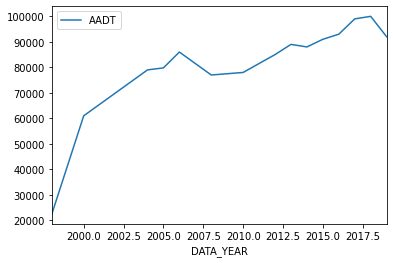

In [72]:
traffic.loc[traffic["SEQUENCE_NUMBER"] == seq].plot(x="DATA_YEAR", y="AADT")

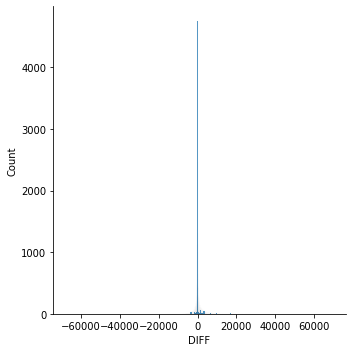

In [42]:
sns.displot(x="DIFF", data=traffic_changes)